# SST retrieval algorithm v 0

## Introduction
The retrieval algorithm is based on the regression retrieval algorithm developed in Alerskans et al., (2020). It consists of a global SST retrieval algorithm, which uses brightness temperatures and anciliary, such as wind speed. The wind speed information can be obtained from either the integrated OEM retrieval or anciliary data. In addition, an optional wind speed retriveal algorithm, based on the 2-stage retrieval algorithm developed in Alerskans et al., (2020) is included here.

As a first version, the algorithm is developed and regression coefficients are derived using data from the ESA CCI Multisensor Matchup Dataset (MMD), which includes PMW observations from AMSR2 and anciliary data from the ERA5 reanalysis. A CIMR-like channel combination is used, following Nielsen-Englyst et al., (2021), which includes the following channels; 6.9, 10.6, 18.7 and 36.5 GHz (vertical and horizontal polarizations).

## Imports and parameter settings

In [1]:
# Library imports
import datetime
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import sys


# Set the random seed
rnseed = 42

# Set project paths
HOME = os.environ['HOME']
PROJECT = HOME + "/Projects/CIMR/DEVALGO/ATBD_SST"
DATA_PATH = PROJECT + "/data"
COEFF_PATH = PROJECT + "/coeffs"


# Data source and algorithm settings
channel_comb = "cimr_like"   # channel combination
ws_input = "retrieval"       #"retreieval": ws retrieval, "oe": consistent OEM input, "nwp": anciliary data input
data_type = "mmd"
mmd_type = "6b"
year = 2015

# Settings
Nlim = 100    # Minimum number of matchups required for robust coefficients
# Wind speed
ws_min, ws_max, dws = 0, 20, 1 # Minimum, maximum and step wind speed
ws_bins = np.arange(ws_min,ws_max,dws, dtype=int)
# Latitude
lat_min, lat_max, dlat = -72, 84, 2 # Minimum, maximum and step latitude
lat_bins = np.arange(lat_min,lat_max,dlat, dtype=int)
# SST
sst_min, sst_max, dsst = -2, 36, 2 # Minimum, maximum and step SST
sst_bins = np.arange(sst_min,sst_max,dsst, dtype=int)
# Orbit
orb_asc, orb_desc = 0, 1 # Ascending and descending orbit
orb_bins = np.array([orb_asc, orb_desc]).astype(int)

## Read input data
Read input data for the derivation of coefficients and subsequent retrieval of SST (and wind speed, if desired)

In [2]:
# Data
data_file = DATA_PATH + "/MMD" + mmd_type + "_drifter_" + str(year) + ".nc"
ncid = nc.Dataset(data_file, mode='r', format="NETCDF4_CLASSIC")

# Number of matchups
nmatchups = ncid.dimensions['matchups'].size

# Variable names
var_names = ['orbit', 'lat', 'lon', 'satza', 'sataz', 'era5_wind_dir', 'era5_phi_rel', 'era5_ws', 'era5_sst', \
             'era5_tcwv', 'era5_clwt', 'tb6vpol', 'tb6hpol', 'tb10vpol', 'tb10hpol', 'tb18vpol', 'tb18hpol', \
             'tb23vpol', 'tb23hpol', 'tb36vpol', 'tb36hpol', 'tb89vpol', 'tb89hpol', 'sga', 'sss', 'insitu_sst', \
             'insitu_time']
# Get the data
data = pd.DataFrame(index=np.arange(nmatchups))
for ivar,var_name in enumerate(var_names):
    data[var_name] = ncid[var_name][:]

# Close the netCDF file
ncid.close()

# Print the first 10 rows of the dataframe to check the content
data.head(10)


,orbit,lat,lon,satza,sataz,era5_wind_dir,era5_phi_rel,era5_ws,era5_sst,era5_tcwv,...,tb23vpol,tb23hpol,tb36vpol,tb36hpol,tb89vpol,tb89hpol,sga,sss,insitu_sst,insitu_time
0,0,56.424183,169.638947,54.849998,158.089996,22.596886,135.493118,17.837044,275.812103,5.054865,...,204.360001,141.500000,215.039993,156.619995,240.199997,197.949997,116.580383,32.953888,275.850006,1.420118e+09
1,0,56.424183,169.638947,54.849998,158.089996,22.297323,135.792679,17.917061,275.812103,5.006155,...,204.360001,141.500000,215.039993,156.619995,240.199997,197.949997,116.580383,32.953888,275.850006,1.420121e+09
2,0,56.424183,169.638947,54.849998,158.089996,22.000429,136.089569,17.997564,275.812103,4.957446,...,204.360001,141.500000,215.039993,156.619995,240.199997,197.949997,116.580383,32.953888,275.950012,1.420125e+09
3,0,56.507004,169.711227,54.849998,158.149994,21.776829,136.373169,18.030928,275.812103,4.892839,...,204.429993,141.729996,215.179993,156.940002,240.350006,198.529999,116.591286,32.961517,275.950012,1.420129e+09
4,0,56.507004,169.711227,54.849998,158.149994,21.900801,136.249207,17.832052,275.812103,4.750621,...,204.429993,141.729996,215.179993,156.940002,240.350006,198.529999,116.591286,32.961517,275.950012,1.420132e+09
5,0,56.507004,169.711227,54.849998,158.149994,22.027569,136.122437,17.633261,275.812103,4.608402,...,204.429993,141.729996,215.179993,156.940002,240.350006,198.529999,116.591286,32.961517,275.950012,1.420136e+09
6,0,56.507004,169.711227,54.849998,158.149994,22.157227,135.992767,17.434559,275.812103,4.466184,...,204.429993,141.729996,215.179993,156.940002,240.350006,198.529999,116.591286,32.961517,275.950012,1.420139e+09
7,0,29.255737,147.076981,54.840000,204.860001,133.625061,71.234932,9.008652,294.177734,11.436308,...,211.240005,150.160004,214.990005,151.309998,252.539993,212.449997,135.669388,34.794151,294.250000,1.420114e+09
8,0,29.255737,147.076981,54.840000,204.860001,132.959351,71.900642,8.651184,294.177734,11.510617,...,211.240005,150.160004,214.990005,151.309998,252.539993,212.449997,135.669388,34.794151,294.250000,1.420117e+09
9,0,29.255737,147.076981,54.840000,204.860001,132.236359,72.623634,8.294987,294.177734,11.584927,...,211.240005,150.160004,214.990005,151.309998,252.539993,212.449997,135.669388,34.794151,294.250000,1.420121e+09


### Data pre-processing
Pre-processing of data includes:
- Quality control (currently only checks for NaNs as an initial QC already has been perfromed)
- Definition of new variables
- Splitting of the dataset into a train and test dataset

In [3]:
# Process the data
data['insitu_datetime'] = pd.to_datetime(data['insitu_time'],unit='s')
data['look_angle'] = data['satza'] - 55.

# Filter the data
# --Remove nans
data.dropna(axis=0,inplace=True)

# Divide the data into train and test data
data_train, data_test = train_test_split(data, test_size=0.3, random_state=rnseed)
data_train.reset_index(inplace=True)
data_test.reset_index(inplace=True)

## Retrieval definition
The main algorithm is a model for retrieving SST, which is based on the regression model developed in Alerskans et al., (2020). It uses CIMR brightness temperatures ($T_B$), Earth incidence angle ($\theta_{EIA}$), wind speed (WS) and the relative angle between wind direction and satellite azimuth angle ($\phi_{rel}$)

$$SST_{r} = c_{0} + \sum_{i=1}^{N_{ch}} (c_{1i} t_{i} + c_{2i} t^{2}_{i} ) + c_{3} \theta + c_{4} WS + \sum_{j=1}^{2} [c_{5j} \cos (j \phi_{rel}) + c_{6j} \sin (j \phi_{rel}) ],$$

where $t_{i} = T_{Bi}-150$, $\theta = \theta_{EIA} - 55$ and $c_0$ - $c_6$ are regression coefficients.

The wind speed input to the SST retrieval algorithm can come from different sources, where the main option is to use the retrieved wind speed from the integrated OEM retrieval. Optionally, anciliary wind speed data can be used. As and additional option, wind speed can be retrieved using a 2-stage retrieval algorithm based on the retrieval developed in Alerskans et al., (2020). Here, CIMR brightness temperatures and Earth incidence angle would be used to retrieved wind speed in two stages. In the first step, a global algorithm is used:

$$WS_{a} = a_{0} + \sum_{i=1}^{N_{ch}} (a_{1i} t_{i} + a_{2i} t^{2}_{i} ) + a_{3} \theta,$$

whereas in the second step, localized wind speed algorithms based on the first-step retrieved wind speed, $WS_a$ is used to developed individual retrieval algorithms for fixed wind speed intervals:

$$WS_{r} = b_{0} + \sum_{i=1}^{N_{ch}} (b_{1i} t_{i} + b_{2i} t^{2}_{i} ) + b_{3} \theta.$$


### General functions

In [4]:
def regression(X,Y):
    """
    Perform linear regression and obtain the regression coefficients (intercept + slope)
     
    Arguments
    ---------
    X: 2D float array
        predictors
    Y: 2D float array
        predictand
     
    Returns
    -------
    intercept: 1D float array
        intercept
    coeffs: 1D float array
        slope
    """
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    intercept = regr.intercept_
    coeffs = regr.coef_

    return intercept, coeffs

In [5]:
def ws_algorithm_selection(data,channel_comb):
    """
    Select WS algorithm based on the chosen channel combination
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    X: 2D float array
        algorithm input variables
    """
    nmatchups = data.shape[0]
    if channel_comb == 'cimr_like':
        # Construct input data for AMSR2 CIMR-like configuration
        ninput = 17
        X = np.full((nmatchups,ninput), fill_value=np.nan)

        X[:,0]  =  data['tb6vpol'] - 150
        X[:,1]  = (data['tb6vpol'] - 150)**2
        X[:,2]  =  data['tb6hpol'] - 150
        X[:,3]  = (data['tb6hpol'] - 150)**2
        X[:,4]  =  data['tb10vpol'] - 150
        X[:,5]  = (data['tb10vpol'] - 150)**2
        X[:,6]  =  data['tb10hpol'] - 150
        X[:,7]  = (data['tb10hpol'] - 150)**2
        X[:,8]  =  data['tb18vpol'] - 150
        X[:,9]  = (data['tb18vpol'] - 150)**2
        X[:,10] =  data['tb18hpol'] - 150
        X[:,11] = (data['tb18hpol'] - 150)**2
        X[:,12] =  data['tb36vpol'] - 150
        X[:,13] = (data['tb36vpol'] - 150)**2
        X[:,14] =  data['tb36hpol'] - 150
        X[:,15] = (data['tb36hpol'] - 150)**2
        X[:,16] = data['look_angle']
    elif channel_comb == 'cimr':
        # Construct input data for CIMR configuration
        ninput = 21
        X = np.full((nmatchups,ninput), fill_value=np.nan)

        X[:,0]  =  data['tb1vpol'] - 150
        X[:,1]  = (data['tb1vpol'] - 150)**2
        X[:,2]  =  data['tb1hpol'] - 150
        X[:,3]  = (data['tb1hpol'] - 150)**2
        X[:,4]  =  data['tb6vpol'] - 150
        X[:,5]  = (data['tb6vpol'] - 150)**2
        X[:,6]  =  data['tb6hpol'] - 150
        X[:,7]  = (data['tb6hpol'] - 150)**2
        X[:,8]  =  data['tb10vpol'] - 150
        X[:,9]  = (data['tb10vpol'] - 150)**2
        X[:,10] =  data['tb10hpol'] - 150
        X[:,11] = (data['tb10hpol'] - 150)**2
        X[:,12] =  data['tb18vpol'] - 150
        X[:,13] = (data['tb18vpol'] - 150)**2
        X[:,14] =  data['tb18hpol'] - 150
        X[:,15] = (data['tb18hpol'] - 150)**2
        X[:,16] =  data['tb36vpol'] - 150
        X[:,17] = (data['tb36vpol'] - 150)**2
        X[:,18] =  data['tb36hpol'] - 150
        X[:,19] = (data['tb36hpol'] - 150)**2
        X[:,20] = data['look_angle']
    else:
        print("Channel combination {} not understood.\nExiting...!".format(channel_comb))
        sys.exit()

    return X

In [6]:
def sst_algorithm_selection(data,channel_comb):
    """
    Select SST algorithm based on the chosen channel combination
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    X: 2D float array
        algorithm input variables
    """
    nmatchups = data.shape[0]
    if channel_comb == 'cimr_like':
        # Construct input data for AMSR-E configuration
        ninput = 22
        X = np.full((nmatchups,ninput), fill_value=np.nan)

        X[:,0]  =  data['tb6vpol'] - 150
        X[:,1]  = (data['tb6vpol'] - 150)**2
        X[:,2]  =  data['tb6hpol'] - 150
        X[:,3]  = (data['tb6hpol'] - 150)**2
        X[:,4]  =  data['tb10vpol'] - 150
        X[:,5]  = (data['tb10vpol'] - 150)**2
        X[:,6]  =  data['tb10hpol'] - 150
        X[:,7]  = (data['tb10hpol'] - 150)**2
        X[:,8]  =  data['tb18vpol'] - 150
        X[:,9]  = (data['tb18vpol'] - 150)**2
        X[:,10] =  data['tb18hpol'] - 150
        X[:,11] = (data['tb18hpol'] - 150)**2
        X[:,12] =  data['tb36vpol'] - 150
        X[:,13] = (data['tb36vpol'] - 150)**2
        X[:,14] =  data['tb36hpol'] - 150
        X[:,15] = (data['tb36hpol'] - 150)**2
        X[:,16] = data['look_angle']
        X[:,17] = data['WSr']
        X[:,18] = np.cos(data['era5_phi_rel'])
        X[:,19] = np.sin(data['era5_phi_rel'])
        X[:,20] = np.cos(2*data['era5_phi_rel'])
        X[:,21] = np.sin(2*data['era5_phi_rel'])
    elif channel_comb == 'cimr':
        # Construct input data for AMSR-E configuration
        ninput = 26
        X = np.full((nmatchups,ninput), fill_value=np.nan)

        X[:,0]  =  data['tb1vpol'] - 150
        X[:,1]  = (data['tb1vpol'] - 150)**2
        X[:,2]  =  data['tb1hpol'] - 150
        X[:,3]  = (data['tb1hpol'] - 150)**2
        X[:,4]  =  data['tb6vpol'] - 150
        X[:,5]  = (data['tb6vpol'] - 150)**2
        X[:,6]  =  data['tb6hpol'] - 150
        X[:,7]  = (data['tb6hpol'] - 150)**2
        X[:,8]  =  data['tb10vpol'] - 150
        X[:,9]  = (data['tb10vpol'] - 150)**2
        X[:,10] =  data['tb10hpol'] - 150
        X[:,11] = (data['tb10hpol'] - 150)**2
        X[:,12] =  data['tb18vpol'] - 150
        X[:,13] = (data['tb18vpol'] - 150)**2
        X[:,14] =  data['tb18hpol'] - 150
        X[:,15] = (data['tb18hpol'] - 150)**2
        X[:,16] =  data['tb36vpol'] - 150
        X[:,17] = (data['tb36vpol'] - 150)**2
        X[:,18] =  data['tb36hpol'] - 150
        X[:,19] = (data['tb36hpol'] - 150)**2
        X[:,20] = data['look_angle']
        X[:,21] = data['WSr']
        X[:,22] = np.cos(data['era5_phi_rel'])
        X[:,23] = np.sin(data['era5_phi_rel'])
        X[:,24] = np.cos(2*data['era5_phi_rel'])
        X[:,25] = np.sin(2*data['era5_phi_rel'])
    else:
        print("Channel combination {} not understood.\nExiting...!".format(channel_comb))
        sys.exit()

    return X

In [7]:
def calculate_coeffs_ws(data,channel_comb):
    """
    Perform regression of wind speed
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    coeffs_all: 1D float array
        regression coefficients
    """
    # Predictors
    X = ws_algorithm_selection(data,channel_comb)
    # Predictand
    Y = data['era5_ws'].values

    # the try...continue structure is to account for cases where we don't have data in a particular bin, then the code moves on
    try:
        # Calculate linear regression coefficients
        intercept, coeffs = regression(X,Y)
        coeffs_all = np.append(intercept,coeffs)

        return coeffs_all
    except:
        return np.full((ninput+1), fill_value=np.nan)

In [8]:
def calculate_coeffs_sst(data,channel_comb):
    """
    Perform regression of SST
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    coeffs_all: 1D float array
        regression coefficients
    """
    # Predictors
    X = sst_algorithm_selection(data,channel_comb)
    # Predictand
    Y = data['insitu_sst'].values

    # the try...continue structure is to account for cases where we don't have data in a particular bin, then the code moves on
    try:
        # Calculate linear regression coefficients
        intercept, coeffs = regression(X,Y)
        coeffs_all = np.append(intercept,coeffs)

        return coeffs_all
    except:
        return np.full((ninput+1), fill_value=np.nan)


In [9]:
def retrieve_ws(data,A,channel_comb):
    """
    Perform WS retrieval
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
     A: 1D float array
         regression coefficients
    channel_comb: str 
        choice of channel combination
     
    Returns
    -------
    WS: 1D float array
        retirved wind speed
    """
    # Settings
    nmatchups = data.shape[0]
    # Predictors
    X = ws_algorithm_selection(data,channel_comb)
    # Add input for the offset/intercept
    X = np.hstack((np.ones((nmatchups,1)),X))
    # Retrieve WS
    WS =  np.dot(A,X.T)

    return WS


In [10]:
def retrieve_sst(data,A,channel_comb):
    """
    Perform SST retrieval
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
     A: 1D float array
         regression coefficients
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    SST: 1D float array
        retirved SST
    """
    # Settings
    nmatchups = data.shape[0]
    # Predictors
    X = sst_algorithm_selection(data,channel_comb)
    # Add input for the offset/intercept
    X = np.hstack((np.ones((nmatchups,1)),X))
    # Retrieve SST
    SST =  np.dot(A,X.T)

    return SST


### Stage 1 wind speed retrieval algorithm
- Derivation of 1st-stage wind speed regression coefficients
- Retrieval of 1st-stage wind speed

In [11]:
def calculate_coeffs_stage_1_ws(data,channel_comb,verbose=False):
    """
    Derivation of stage 1 wind speed regression coefficients.
    Global coefficients (i.e. based on the whole dataset) is derived.
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice fo channel combination
    verbose: logical
        logical for verbosity of function
     
    Returns
    -------
    """
    print("\nCalculate WS stage 1 coefficients")

    # Get coefficients
    coeffs_all = calculate_coeffs_ws(data,channel_comb)

    if not np.all(np.isnan(coeffs_all)):
        if verbose:
            print("Save WS stage 1 coefficients")
        coeffs_file = COEFF_PATH + "/ws/coeffs_ws_stage_1.npy"
        np.save(coeffs_file,coeffs_all)

In [12]:
def retrieve_stage_1_ws(data,channel_comb):
    """
    Retrieval of global stage 1 wind speeds.
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    WSa: 1D float array
        retrieved wind speed
    """
    print("\nRetrieve stage 1 WS")

    # Load coefficients
    coeffs_file = COEFF_PATH + "/ws/coeffs_ws_stage_1.npy"
    A = np.load(coeffs_file)

    # Retrieve WS
    WSa =  retrieve_ws(data,A,channel_comb)

    return WSa

### Stage 2 wind speed retrieval algorithm
- Derivation of 2nd-stage wind speed regression coefficients
- Retrieval of 2nd-stage wind speed

In [13]:
def calculate_coeffs_stage_2_ws(data,ws_bins,channel_comb,verbose=False):
    """
    Derivation of stage 2 wind speed regression coefficients.
    Localized coeffients for specified wind speed intervals are derived.
    The wind speed intervals are based on the 1st-stage retrieved wind speed.
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    ws_bins: 1D float array
        wind speed bin intervals
    channel_comb: str
        choice of channel combination
    verbose: logical
        logical for verbosity of function
     
    Returns
    -------
    """
    print("\nCalculate WS stage 2 coefficients")

    # Settings
    ws_step = ws_bins[1] - ws_bins[0]

    # Loop through bins
    for iws in ws_bins:
        # Find the data that belongs to the current wind speed bin 
        mask_sub = ( (data['WSa'].values > iws) & (data['WSa'].values <= iws+ws_step) )

        # Check so that there is enough data
        if np.sum(mask_sub) > Nlim:
            data_sub = data.loc[mask_sub]

            # Calculate coefficients
            coeffs_all = calculate_coeffs_ws(data_sub,channel_comb)

            if not np.all(np.isnan(coeffs_all)):
                if verbose:
                    print("Save WS stage 2 coefficients for wind speed bin {}-{} ms-1".format(iws,iws+1))
                coeffs_file = COEFF_PATH + "/ws/coeffs_ws_stage_2_wsbin_"+str(iws)+".npy"
                np.save(coeffs_file,coeffs_all)

In [14]:
def retrieve_stage_2_ws(data,ws_bins,channel_comb,verbose=False):
    """
    Retrieval of local stage 2 wind speeds.
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    ws_bins: 1D float array
        wind speed bins for localized algoritm
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    WSr: 1D float array
        retrieved wind speed
    """
    print("\nRetrieve stage 2 WS")

    # Settings
    nmatchups = data.shape[0]
    ws_step = ws_bins[1] - ws_bins[0]

    # Initialize array
    WSr = np.full((nmatchups), fill_value=np.nan, dtype=np.float32)

    # Loop through bins
    for iws in ws_bins:
        if verbose:
            print("Working on wind speed bin {}".format(iws))
        # Find the data that belongs to the current wind speed bin 
        mask_sub = (data['WSa'].values > iws) & (data['WSa'].values <= iws+ws_step)

        # Check so that there is data
        if np.sum(mask_sub) > 0:
            idx_sub = np.argwhere(mask_sub)[:,0]
            data_sub = data.loc[mask_sub]
            data_sub.reset_index(inplace=True,drop=True)

            # Load the appropriate coefficient file
            coeffs_file = COEFF_PATH + "/ws/coeffs_ws_stage_2_wsbin_"+str(iws)+".npy"
            if os.path.isfile(coeffs_file):
                B1 = np.load(coeffs_file)
                isnan_B1 = False
            else:
                isnan_B1 = True

            # If interpolating, find the nearest wind speed bin of our measurement
            for inear in range(2):
                if inear == 0:
                    # Lower limit
                    iws_near = iws - ws_step
                    mask_int = (data_sub['WSa'].values < iws + ws_step/2)
                    if np.sum(mask_int) == 0:
                        continue
                    idx_int = np.argwhere(mask_int)[:,0]
                    data_int = data_sub.loc[mask_int]
                else:
                    # Upper limit
                    iws_near = iws + ws_step
                    mask_int = (data_sub['WSa'].values >= iws + ws_step/2)
                    if np.sum(mask_int) == 0:
                        continue
                    idx_int = np.argwhere(mask_int)[:,0]
                    data_int = data_sub.loc[mask_int]

                # Check if there are coefficients for that bin and load
                coeffs_file_near = COEFF_PATH + "/ws/coeffs_ws_stage_2_wsbin_"+str(iws_near)+".npy"
                if os.path.isfile(coeffs_file_near):
                    B2 = np.load(coeffs_file_near)
                    isnan_B2 = False
                elif os.path.isfile(coeffs_file):
                    isnan_B2 = True
                    B2 = B1.copy()
                else:
                    # No coefficients for current or closest ws bin -> no retrieval
                    if verbose:
                        print("Warning: Coefficients do not exist for current wind speed bin {} or closest bin. WS=NaN...!".format(iws))
                    WSr[idx_sub[idx_int]] = np.nan
                    continue

                # Retrieve WS
                WSr_i1 = retrieve_ws(data_int,B1,channel_comb)
                WSr_i2 = retrieve_ws(data_int,B2,channel_comb)

                # Define interpolation weights
                w1 = np.abs(data_int['WSa'].values - iws)/ws_step
                w2 = 1 - w1

                # Reset weights as we don't have either B1 or B2 coefficients
                if (isnan_B1 | isnan_B2):
                    if (isnan_B1): w1 = 0.
                    if (isnan_B2): w2 = 0.

                    wsum = w1 + w2
                    w1 = w1 / wsum
                    w2 = w2 / wsum

                # Interpolate between WSr_i1 and WSr_i2
                WSr_int = WSr_i1 * w1 + WSr_i2 * w2

                # Assign to the correct WSr elements
                WSr[idx_sub[idx_int]] = WSr_int.copy()

    return WSr

### SST retrieval algorithm
- Derivation of SST regression coefficients
- Retrieval of SST

In [15]:
def calculate_coeffs_global_sst(data,channel_comb,verbose=False):
    """
    Derivation of SST coefficients.
    Global coeffients (i.e. based on the whole dataset) are derived.
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice of channel combination
    verbose: logical
        logical for verbosity of function
     
    Returns
    -------
    """
    print("\nCalculate SST global coefficients")

    # Exclude WSr nans
    data_sub = data.dropna(axis=0)

    # Get coefficients
    coeffs_all = calculate_coeffs_sst(data_sub,channel_comb)

    if not np.all(np.isnan(coeffs_all)):
        if verbose:
            print("Save SST global coefficients")
        coeffs_file = COEFF_PATH + "/sst/coeffs_sst_global.npy"
        np.save(coeffs_file,coeffs_all)


In [16]:
def retrieve_global_sst(data,channel_comb):
    """
    Retrieval of global SSTs.
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    channel_comb: str
        choice of channel combination
     
    Returns
    -------
    SSTr: 1D float array
        retrieved SST
    """
    print("\nRetrieve global SST")

    # Load coefficients
    coeffs_file = COEFF_PATH + "/sst/coeffs_sst_global.npy"
    A = np.load(coeffs_file)

    # Retrieve SST
    SSTr =  retrieve_sst(data,A,channel_comb)

    return SSTr


### Derivation of regression coefficients
Here, regression coefficients for the SST retrieval algorithm is derived.
In addition, if the option is set to use retrieved wind speed in the SST algorithm, the 1st- and 2nd-stage wind speed coefficients are retrieved here as well.

In [17]:
# Settings
derive_stage_1_ws_coeffs = True
derive_stage_2_ws_coeffs = True
derive_global_sst_coeffs = True


if ws_input == "retrieval":
    # ------------------------------
    # Wind speed retrieval - Stage 1
    # ------------------------------
    # Calculate coefficients
    if derive_stage_1_ws_coeffs:
        calculate_coeffs_stage_1_ws(data_train,channel_comb)

    # Retrieve WSa
    WSa = retrieve_stage_1_ws(data_train,channel_comb)
    data_train['WSa'] = WSa

    
if ws_input == "retrieval":
    # ------------------------------
    # Wind speed retrieval - Stage 2
    # ------------------------------
    # Calculate coefficients
    if derive_stage_2_ws_coeffs:
        calculate_coeffs_stage_2_ws(data_train,ws_bins,channel_comb)

    # Retrieve WSr
    WSr = retrieve_stage_2_ws(data_train,ws_bins,channel_comb)
    data_train['WSr'] = WSr

elif ws_input == "oe":
    # Input from the integrated OEM retrieval - not implemented yet
    pass

elif ws_input == "nwp":
    # Input from NWP ERA5 data
    data_train['WSr'] = data_train['era5_ws']

    
# -----------------------
# SST retrieval - Global
# -----------------------
# Calculate coefficients
if derive_global_sst_coeffs:
    calculate_coeffs_global_sst(data_train,channel_comb)

## Retrieve SSTr
#SSTr = retrieve_global_sst(data_train,channel_comb)
#data_train['SSTr_global'] = SSTr

print("...Done!")


Calculate WS stage 1 coefficients



Retrieve stage 1 WS



Calculate WS stage 2 coefficients



Retrieve stage 2 WS



Calculate SST global coefficients


...Done!


### Performance analysis
Use the test dataset to retrieve SST and evaluate the performance of the retrieval algorithm.

#### Analysis functions
Define functions used for evaluating the performance of the algorithm.

In [18]:
def print_stats(data,SSTr):
    """
    Print the overall perfromance metrics for the SST retrieval algorithm.

    Arguments
    ---------
    data: pandas DataFrame
        dataset
    SSTr: 1D float array
        retrieved SST
        
    Returns
    -------
    Prints output
    """
    dif_mean = np.nanmean(SSTr - data['insitu_sst'])
    dif_mae = np.nanmean(np.abs(SSTr - data['insitu_sst']))
    dif_std = np.nanstd(SSTr - data['insitu_sst'])
    dif_rmse = np.sqrt(np.nanmean((SSTr - data['insitu_sst'])**2))

    print('PMW retrievals - drifter observations')
    print('-------------------------------------')
    print('Mean: ' + str(round(dif_mean,3)) + ' K.')
    print('MAE:  ' + str(round(dif_mae,3)) + ' K.')
    print('St.d: ' + str(round(dif_std,3)) + ' K.')
    print('RMSE: ' + str(round(dif_rmse,3)) + ' K.')

In [19]:
def plot_scatter_data(data,pmin_sst,pmax_sst,pdsst):
    """
    Scatterplot of retrieved SST (y-axis) vs. drifter in situ SST (x-axis).
     
    Arguments
    ---------
    data: pandas DataFrame
        dataset
    pmin_sst: float
        SST min (x- and y-min) limits for plot
    pmax_sst: float
        SST max (x- and y-max) limits for plot
    
    Returns
    -------
    Outputs a figure
    """
    fig, ax = plt.subplots(figsize=[8,6])
    ax.scatter(data['insitu_sst']-273.15,data['SSTr_global']-273.15)
    ax.plot([pmin_sst,pmax_sst],[pmin_sst,pmax_sst], linestyle='-', color='k', linewidth=1.2)
    ax.grid(True)
    
    ax.set_xlabel('in situ SST ($^{\circ}$C)',fontsize=13)
    ax.set_ylabel('retrieved PMW SST ($^{\circ}$C)',fontsize=13)
    ax.set_xlim([pmin_sst, pmax_sst])
    ax.set_ylim([pmin_sst, pmax_sst])
    ax.set_xticks(np.arange(pmin_sst,pmax_sst+pdsst,pdsst))
    ax.set_yticks(np.arange(pmin_sst,pmax_sst+pdsst,pdsst))
    ax.set_xticklabels(np.arange(pmin_sst,pmax_sst+pdsst,pdsst),fontsize=12)
    ax.set_yticklabels(np.arange(pmin_sst,pmax_sst+pdsst,pdsst),fontsize=12)

    plt.show()

#### Retrievals
Retrieve wind speed (if this option is set) and SST

In [20]:
# WS data
if ws_input == "retrieval":
    # Retrieve WSa
    WSa = retrieve_stage_1_ws(data_test,channel_comb)
    data_test['WSa'] = WSa
    # Retrieve WSr
    WSr = retrieve_stage_2_ws(data_test,ws_bins,channel_comb)
    data_test['WSr'] = WSr
elif ws_input == "oe":
    # Not implemented yet
    pass
elif ws_input == "nwp":
    print("ERA5 WS input")
    data_test['WSr'] = data_test['era5_ws']
    
# Retrieve SSTr
SSTr = retrieve_global_sst(data_test,channel_comb)
data_test['SSTr_global'] = SSTr


Retrieve stage 1 WS



Retrieve stage 2 WS



Retrieve global SST


In [21]:
# Only use the common data, i.e. remove any NaNs
good_data = ( ~np.isnan(data_test['SSTr_global'].values) )
data_test = data_test.loc[good_data,:]
data_test.reset_index(inplace=True,drop=True)

In [22]:
print("\nTEST DATASET - Global SST retrieval")
print("======================================")
print_stats(data_test,data_test['SSTr_global'])


TEST DATASET - Global SST retrieval
PMW retrievals - drifter observations
-------------------------------------
Mean: 0.0 K.
MAE:  0.555 K.
St.d: 0.748 K.
RMSE: 0.748 K.


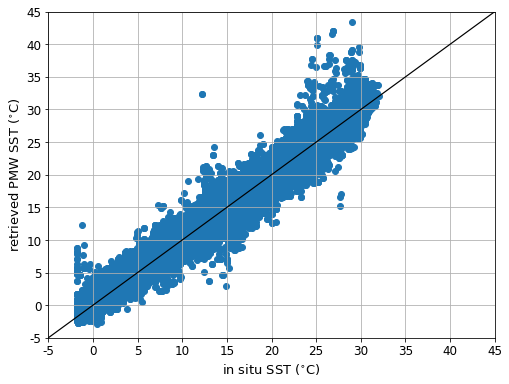

In [23]:
# Plot scatter plot of retrieved vs in situ SST
pmin_sst = -5
pmax_sst = 45
pdsst = 5
plot_scatter_data(data_test,pmin_sst,pmax_sst,pdsst)